<a href="https://colab.research.google.com/github/adamlouisky/colab_code_deep-learning/blob/master/improving_neural_net_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 提高神经网络性能

 **学习目标**：通过将特征标准化并应用各种优化算法来提高神经网络的性能

**注意**：本练习中介绍的优化方法并非专门针对神经网络；这些方法可有效改进大多数类型的模型。

 ## 设置

首先，我们将加载数据。

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [5]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2657.0,541.0,1434.0,503.2,3.9,2.0
std,2.1,2.0,12.6,2200.3,424.4,1128.7,387.4,1.9,1.1
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1469.0,299.0,791.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2139.5,435.0,1174.0,411.0,3.6,1.9
75%,37.7,-118.0,37.0,3156.0,646.0,1723.0,604.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,52.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2611.6,535.5,1419.0,496.5,3.8,2.0
std,2.1,2.0,12.6,2130.2,414.5,1192.6,377.4,1.9,1.3
min,32.5,-124.3,2.0,8.0,1.0,13.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1446.0,292.0,785.8,278.0,2.6,1.5
50%,34.3,-118.5,29.0,2101.0,429.5,1149.0,404.0,3.5,1.9
75%,37.7,-118.0,37.0,3133.5,655.2,1714.0,607.0,4.7,2.3
max,42.0,-114.6,52.0,30401.0,4957.0,35682.0,4769.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,208.1
std,116.3
min,15.0
25%,120.2
50%,180.2
75%,265.8
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,205.4
std,115.3
min,15.0
25%,118.4
50%,180.5
75%,263.3
max,500.0


 ## 训练神经网络

接下来，我们将训练神经网络。

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training model...
RMSE (on training data):
  period 00 : 129.88
  period 01 : 109.13
  period 02 : 101.72
  period 03 : 102.62
  period 04 : 98.45
  period 05 : 99.17
  period 06 : 97.38
  period 07 : 98.73
  period 08 : 98.40
  period 09 : 98.75
Model training finished.
Final RMSE (on training data):   98.75
Final RMSE (on validation data): 98.46


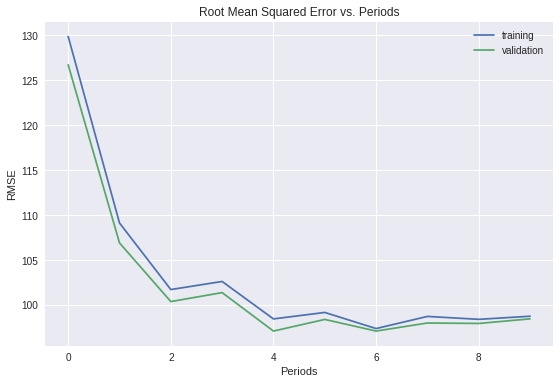

In [9]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 线性缩放
将输入标准化以使其位于 (-1, 1) 范围内可能是一种良好的标准做法。这样一来，SGD 在一个维度中采用很大步长（或者在另一维度中采用很小步长）时不会受阻。数值优化的爱好者可能会注意到，这种做法与使用预调节器 (Preconditioner) 的想法是有联系的。

In [0]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

 ## 任务 1：使用线性缩放将特征标准化

**将输入标准化到 (-1, 1) 这一范围内。**

**花费 5 分钟左右的时间来训练和评估新标准化的数据。您能达到什么程度的效果？**

一般来说，当输入特征大致位于相同范围时，神经网络的训练效果最好。

对您的标准化数据进行健全性检查。（如果您忘了将某个特征标准化，会发生什么情况？）

In [13]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  #
  # Your code here: normalize the inputs.
  #
  pass

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

AttributeError: ignored

 ### 解决方案

点击下方即可查看一种可能的解决方案。

 由于标准化会使用最小值和最大值，我们必须确保在整个数据集中一次性完成该操作。

我们之所以可以这样做，是因为我们所有的数据都在一个 DataFrame 中。如果我们有多个数据集，则最好从训练集中导出标准化参数，然后以相同方式将其应用于测试集。

Training model...
RMSE (on training data):
  period 00 : 210.88
  period 01 : 117.04
  period 02 : 106.86
  period 03 : 92.41
  period 04 : 80.61
  period 05 : 76.90
  period 06 : 74.65
  period 07 : 73.57
  period 08 : 72.71
  period 09 : 72.15
Model training finished.
Final RMSE (on training data):   72.15
Final RMSE (on validation data): 70.59


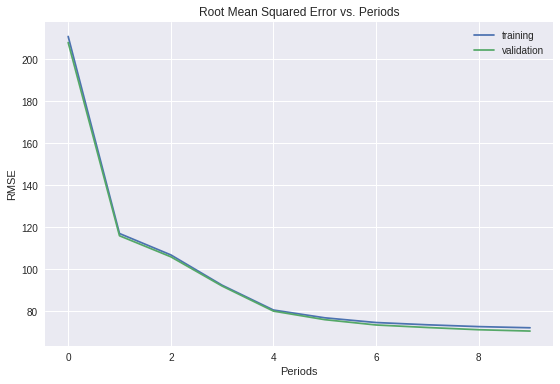

In [14]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ## 任务 2：尝试其他优化器

** 使用 AdaGrad 和 Adam 优化器并对比其效果。**

AdaGrad 优化器是一种备选方案。AdaGrad 的核心是灵活地修改模型中每个系数的学习率，从而单调降低有效的学习率。该优化器对于凸优化问题非常有效，但不一定适合非凸优化问题的神经网络训练。您可以通过指定 `AdagradOptimizer`（而不是 `GradientDescentOptimizer`）来使用 AdaGrad。请注意，对于 AdaGrad，您可能需要使用较大的学习率。

对于非凸优化问题，Adam 有时比 AdaGrad 更有效。要使用 Adam，请调用 `tf.train.AdamOptimizer` 方法。此方法将几个可选超参数作为参数，但我们的解决方案仅指定其中一个 (`learning_rate`)。在应用设置中，您应该谨慎指定和调整可选超参数。

In [0]:
#
# YOUR CODE HERE: Retrain the network using Adagrad and then Adam.
#

 ### 解决方案

点击下方即可查看解决方案

 首先，我们来尝试 AdaGrad。

Training model...
RMSE (on training data):
  period 00 : 80.03
  period 01 : 76.13
  period 02 : 74.50
  period 03 : 71.87
  period 04 : 77.76
  period 05 : 70.44
  period 06 : 74.79
  period 07 : 69.61
  period 08 : 69.32
  period 09 : 69.57
Model training finished.
Final RMSE (on training data):   69.57
Final RMSE (on validation data): 67.79


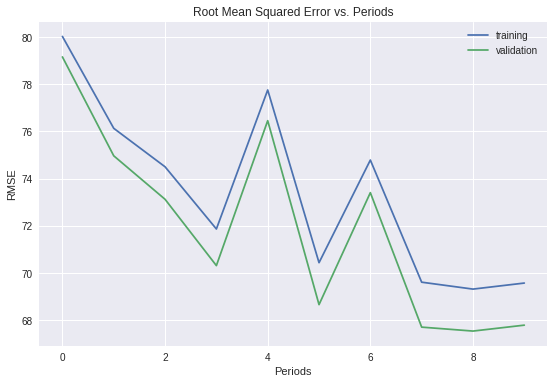

In [15]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 现在，我们来尝试 Adam。

Training model...
RMSE (on training data):
  period 00 : 237.10
  period 01 : 235.35
  period 02 : 232.19
  period 03 : 227.64
  period 04 : 221.14
  period 05 : 212.06
  period 06 : 200.97
  period 07 : 188.17
  period 08 : 173.95
  period 09 : 158.85
Model training finished.
Final RMSE (on training data):   158.85
Final RMSE (on validation data): 155.80


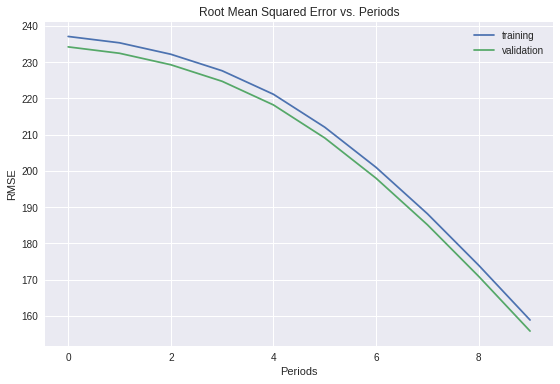

In [17]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 我们并排输出损失指标的图表。

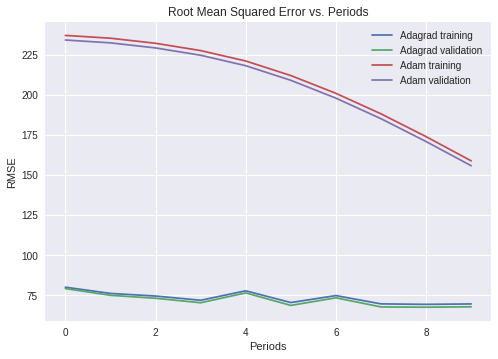

In [18]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

 ## 任务 3：尝试其他标准化方法

**尝试对各种特征使用其他标准化方法，以进一步提高性能。**

如果仔细查看转换后数据的汇总统计信息，您可能会注意到，对某些特征进行线性缩放会使其聚集到接近 `-1` 的位置。

例如，很多特征的中位数约为 `-0.8`，而不是 `0.0`。

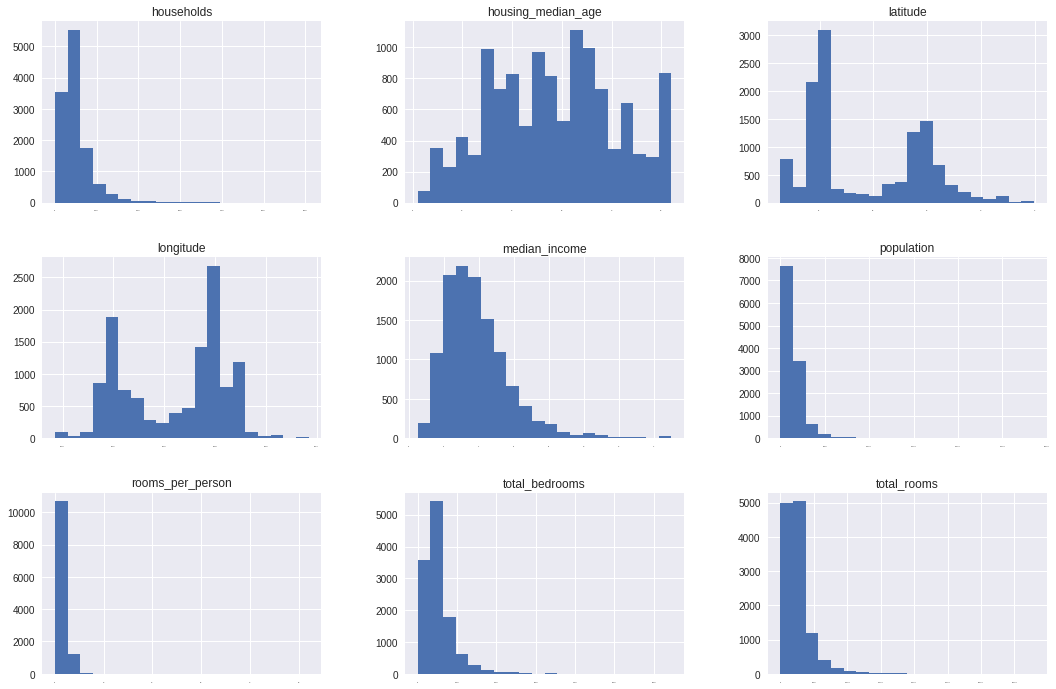

In [19]:
_ = training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=2)

 通过选择其他方式来转换这些特征，我们可能会获得更好的效果。

例如，对数缩放可能对某些特征有帮助。或者，截取极端值可能会使剩余部分的信息更加丰富。

In [0]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

 上述部分包含一些额外的标准化函数。请尝试其中的某些函数，或添加您自己的函数。

请注意，如果您将目标标准化，则需要将网络的预测结果非标准化，以便比较损失函数的值。

In [21]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  #
  # YOUR CODE HERE: Normalize the inputs.
  #
  pass

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

AttributeError: ignored

 ### 解决方案

点击下方即可查看一种可能的解决方案。

 以上这些只是我们能想到的处理数据的几种方法。其他转换方式可能会更好！

`households`、`median_income` 和 `total_bedrooms` 在对数空间内均呈现为正态分布。

如果 `latitude`、`longitude` 和 `housing_median_age` 像之前一样进行线性缩放，效果可能会更好。

`population`、`totalRooms` 和 `rooms_per_person` 具有几个极端离群值。这些值似乎过于极端，以至于我们无法利用对数标准化处理这些离群值。因此，我们直接截取掉这些值。

Training model...
RMSE (on training data):
  period 00 : 101.43
  period 01 : 83.32
  period 02 : 74.95
  period 03 : 73.15
  period 04 : 72.09
  period 05 : 71.42
  period 06 : 71.06
  period 07 : 70.63
  period 08 : 70.44
  period 09 : 69.99
Model training finished.
Final RMSE (on training data):   69.99
Final RMSE (on validation data): 69.09


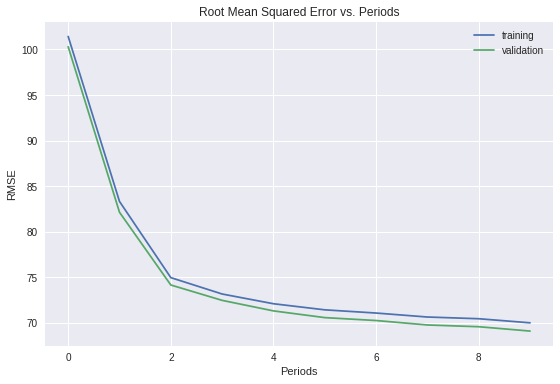

In [22]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  processed_features = pd.DataFrame()

  processed_features["households"] = log_normalize(examples_dataframe["households"])
  processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return processed_features

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.15),
    steps=1000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ## 可选挑战：仅使用纬度和经度特征

**训练仅使用纬度和经度作为特征的神经网络模型。**

房地产商喜欢说，地段是房价的唯一重要特征。
我们来看看能否通过训练仅使用纬度和经度作为特征的模型来证实这一点。

只有我们的神经网络模型可以从纬度和经度中学会复杂的非线性规律，才能达到我们想要的效果。

**注意**：我们可能需要一个网络结构，其层数比我们之前在练习中使用的要多。

In [0]:
#
# YOUR CODE HERE: Train the network using only latitude and longitude
#

 ### 解决方案

点击下方即可查看可能的解决方案。

 最好使纬度和经度保持标准化状态：

Training model...
RMSE (on training data):
  period 00 : 112.25
  period 01 : 108.90
  period 02 : 103.19
  period 03 : 101.90
  period 04 : 100.86
  period 05 : 100.43
  period 06 : 99.71
  period 07 : 99.82
  period 08 : 99.48
  period 09 : 99.63
Model training finished.
Final RMSE (on training data):   99.63
Final RMSE (on validation data): 97.93


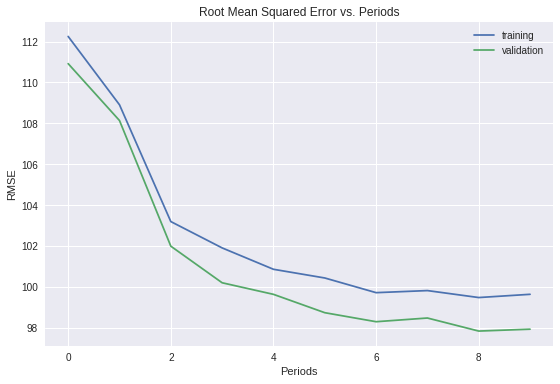

In [23]:
def location_location_location(examples_dataframe):
  """Returns a version of the input `DataFrame` that keeps only the latitude and longitude."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  return processed_features

lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = lll_dataframe.head(12000)
lll_validation_examples = lll_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=500,
    batch_size=50,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets)

 对于只有两个特征的模型，结果并不算太糟。当然，地产价值在短距离内仍然可能有较大差异。